In [2]:
import pandas as pd
import numpy as np
from sklearn import preprocessing

from sklearn.ensemble import RandomForestRegressor


from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.size'] = 18
%matplotlib inline

from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [2]:
!pip install shap --upgrade --user

In [2]:
import shap
shap.initjs()

# SHAPによる非線形のFit
## 基礎編（前回）：支出によるShareとSHAPのShareの差を確認し、投資金額が妥当化を判断する
## 発展編（今回）：AdstockやProphetの時系列成分を入れて算定
### 1.Prophetのみを使ってモデリング
### 2.Prophet＋Adstockを使ってモデリング

In [5]:
data = pd.read_csv("data_raw_Robyn.csv", parse_dates = ["DATE"])
data.columns = [col.lower() if col in ["DATE"] else col for col in data.columns]
data

,date,revenue,tv_S,ooh_S,print_S,facebook_I,search_clicks_P,search_S,competitor_sales_B,facebook_S,events,newsletter
0,2015-11-23,2.754372e+06,167687.6,0,95463.666667,7.290385e+07,0.000000,0,8125009,228213.987444,na,19401.653846
1,2015-11-30,2.584277e+06,214600.9,0,0.000000,1.658110e+07,29511.715457,31000,7901549,34258.573511,na,14791.000000
2,2015-12-07,2.547387e+06,0.0,248022,3404.000000,4.995477e+07,36132.358958,28400,8300197,127691.261335,na,14544.000000
3,2015-12-14,2.875220e+06,625877.3,0,132600.000000,3.164930e+07,36804.210958,31900,8122883,84014.720306,na,2800.000000
4,2015-12-21,2.215953e+06,0.0,520005,0.000000,8.802269e+06,28401.744069,27100,7105985,20687.478156,na,15478.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
203,2019-10-14,2.456240e+06,0.0,60433,153723.666667,0.000000e+00,152840.323412,112100,7612762,0.000000,na,28157.000000
204,2019-10-21,2.182825e+06,154917.6,0,0.000000,5.688196e+07,103680.047821,103700,6701667,133624.575524,na,10644.000000
205,2019-10-28,2.377707e+06,21982.5,14094,17476.000000,0.000000e+00,138387.704138,114700,7688920,0.000000,na,9597.000000
206,2019-11-04,2.732825e+06,22453.0,0,24051.333333,0.000000e+00,151707.990462,134100,8815710,0.000000,na,90189.000000


In [6]:
data.head()

,date,revenue,tv_S,ooh_S,print_S,facebook_I,search_clicks_P,search_S,competitor_sales_B,facebook_S,events,newsletter
0,2015-11-23,2.754372e+06,167687.6,0,95463.666667,7.290385e+07,0.000000,0,8125009,228213.987444,na,19401.653846
1,2015-11-30,2.584277e+06,214600.9,0,0.000000,1.658110e+07,29511.715457,31000,7901549,34258.573511,na,14791.000000
2,2015-12-07,2.547387e+06,0.0,248022,3404.000000,4.995477e+07,36132.358958,28400,8300197,127691.261335,na,14544.000000
3,2015-12-14,2.875220e+06,625877.3,0,132600.000000,3.164930e+07,36804.210958,31900,8122883,84014.720306,na,2800.000000
4,2015-12-21,2.215953e+06,0.0,520005,0.000000,8.802269e+06,28401.744069,27100,7105985,20687.478156,na,15478.000000


In [7]:
holidays = pd.read_csv("holidays_daily.csv", parse_dates = ["ds"])
holidays["begin_week"] = holidays["ds"].dt.to_period('W-SUN').dt.start_time
#週の初めてで休日を統一
holidays_weekly = holidays.groupby(["begin_week", "country", "year"], as_index = False).agg({'holiday':'#'.join, 'country': 'first', 'year': 'first'}).rename(columns = {'begin_week': 'ds'})
holidays_weekly_de = holidays_weekly.query("(country == 'DE')").copy()
holidays_weekly_de

,ds,holiday,country,year
12,1994-12-26,Neujahr,DE,1995
183,1995-04-10,Karfreitag,DE,1995
222,1995-04-17,Ostermontag,DE,1995
270,1995-05-01,Erster Mai,DE,1995
346,1995-05-22,Christi Himmelfahrt,DE,1995
...,...,...,...,...
35445,2044-05-23,Christi Himmelfahrt,DE,2044
35481,2044-06-06,Pfingstmontag,DE,2044
35646,2044-10-03,Tag der Deutschen Einheit,DE,2044
35781,2044-12-19,Erster Weihnachtstag,DE,2044


In [8]:
prophet_data = data.rename(columns = {'revenue': 'y', 'date': 'ds'})
#Prophetの成分を元データに入れる
prophet_data = pd.concat([prophet_data, pd.get_dummies(prophet_data["events"], drop_first = True, prefix = "events")], axis = 1)
prophet_data.head()

,ds,y,tv_S,ooh_S,print_S,facebook_I,search_clicks_P,search_S,competitor_sales_B,facebook_S,events,newsletter,events_event2,events_na
0,2015-11-23,2.754372e+06,167687.6,0,95463.666667,7.290385e+07,0.000000,0,8125009,228213.987444,na,19401.653846,0,1
1,2015-11-30,2.584277e+06,214600.9,0,0.000000,1.658110e+07,29511.715457,31000,7901549,34258.573511,na,14791.000000,0,1
2,2015-12-07,2.547387e+06,0.0,248022,3404.000000,4.995477e+07,36132.358958,28400,8300197,127691.261335,na,14544.000000,0,1
3,2015-12-14,2.875220e+06,625877.3,0,132600.000000,3.164930e+07,36804.210958,31900,8122883,84014.720306,na,2800.000000,0,1
4,2015-12-21,2.215953e+06,0.0,520005,0.000000,8.802269e+06,28401.744069,27100,7105985,20687.478156,na,15478.000000,0,1


In [9]:
prophet = Prophet(yearly_seasonality=True, holidays=holidays_weekly_de)
prophet.add_regressor(name = "events_event2")
prophet.add_regressor(name = "events_na")

In [10]:
prophet.fit(prophet_data[["ds", "y", "events_event2", "events_na"]])
prophet_predict = prophet.predict(prophet_data[["ds", "y", "events_event2", "events_na"]])

08:22:23 - cmdstanpy - INFO - Chain [1] start processing
08:22:24 - cmdstanpy - INFO - Chain [1] done processing


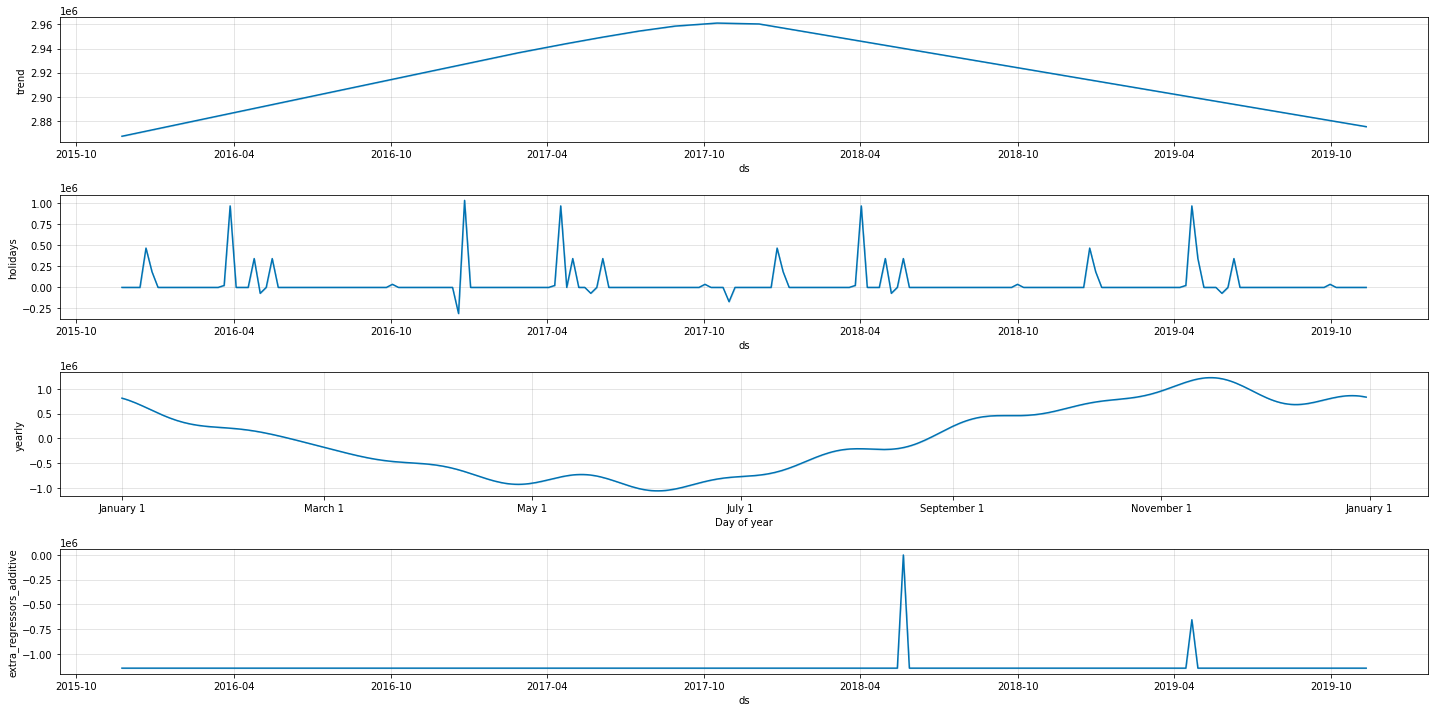

In [11]:
plot = prophet.plot_components(prophet_predict, figsize = (20, 10))

In [20]:
prophet_columns = [col for col in prophet_predict.columns if (col.endswith("upper") == False) & (col.endswith("lower") == False)]

In [25]:
prophet_predict[prophet_columns].filter(like="events_")

,events_event2,events_na
0,0.0,-1.144459e+06
1,0.0,-1.144459e+06
2,0.0,-1.144459e+06
3,0.0,-1.144459e+06
4,0.0,-1.144459e+06
...,...,...
203,0.0,-1.144459e+06
204,0.0,-1.144459e+06
205,0.0,-1.144459e+06
206,0.0,-1.144459e+06


In [12]:
prophet_columns = [col for col in prophet_predict.columns if (col.endswith("upper") == False) & (col.endswith("lower") == False)]
events_numeric = prophet_predict[prophet_columns].filter(like = "events_").sum(axis = 1)


final_data = data.copy()
final_data["trend"] = prophet_predict["trend"]
final_data["season"] = prophet_predict["yearly"]
final_data["holiday"] = prophet_predict["holidays"]
final_data["events"] = (events_numeric - np.min(events_numeric)).values

In [13]:
data = final_data

In [15]:
target = "revenue"
media_channels = ["tv_S", "ooh_S", "print_S", "facebook_S", "search_S"]
organic_channels = ["newsletter"]
#features = ["competitor_sales_B", "events"] + media_channels + organic_channels
features = ["trend", "season", "holiday", "competitor_sales_B", "events"] + media_channels + organic_channels

In [16]:
n_estimators = 5
min_samples_leaf = 1
min_samples_split = 2
max_depth = 4
ccp_alpha = 0.3
bootstrap = True

scores = []

tscv = TimeSeriesSplit(n_splits=3, test_size = 20)

for train_index, test_index in tscv.split(data):
    x_train = data.iloc[train_index][features]
    y_train =  data[target].values[train_index]

    x_test = data.iloc[test_index][features]
    y_test = data[target].values[test_index]

    #ランダムフォレストに投入
    params = {"n_estimators": n_estimators, 
               "min_samples_leaf":min_samples_leaf, 
               "min_samples_split" : min_samples_split,
               "max_depth" : max_depth, 
               "ccp_alpha" : ccp_alpha, 
               "bootstrap" : bootstrap
             }

    rf = RandomForestRegressor(random_state=0, **params)
    print(x_train.isna().sum())
    rf.fit(x_train, y_train)
    prediction = rf.predict(x_test)

    rmse = mean_squared_error(y_true = y_test, y_pred = prediction, squared = False)
    scores.append(rmse)

trend                 0
season                0
holiday               0
competitor_sales_B    0
events                0
tv_S                  0
ooh_S                 0
print_S               0
facebook_S            0
search_S              0
newsletter            0
dtype: int64
trend                 0
season                0
holiday               0
competitor_sales_B    0
events                0
tv_S                  0
ooh_S                 0
print_S               0
facebook_S            0
search_S              0
newsletter            0
dtype: int64
trend                 0
season                0
holiday               0
competitor_sales_B    0
events                0
tv_S                  0
ooh_S                 0
print_S               0
facebook_S            0
search_S              0
newsletter            0
dtype: int64


In [17]:
rf.feature_importances_

array([0.00992808, 0.08807126, 0.03680943, 0.83513018, 0.0045275 ,
       0.02195765, 0.0025125 , 0.        , 0.        , 0.        ,
       0.0010634 ])

In [18]:
features

['trend',
 'season',
 'holiday',
 'competitor_sales_B',
 'events',
 'tv_S',
 'ooh_S',
 'print_S',
 'facebook_S',
 'search_S',
 'newsletter']

In [19]:
prediction = rf.predict(data[features])

In [20]:
scores

[139846.06333807527, 261323.12097674538, 126795.7651253152]

In [21]:
data["revenue"].mean()

1822142.7724358966

In [22]:
for score in scores:
    print(score/data["revenue"].mean())

0.07674813711283707
0.1434152827812722
0.06958607582424


In [23]:
def nrmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2)) / (np.max(y_true) - np.min(y_true))

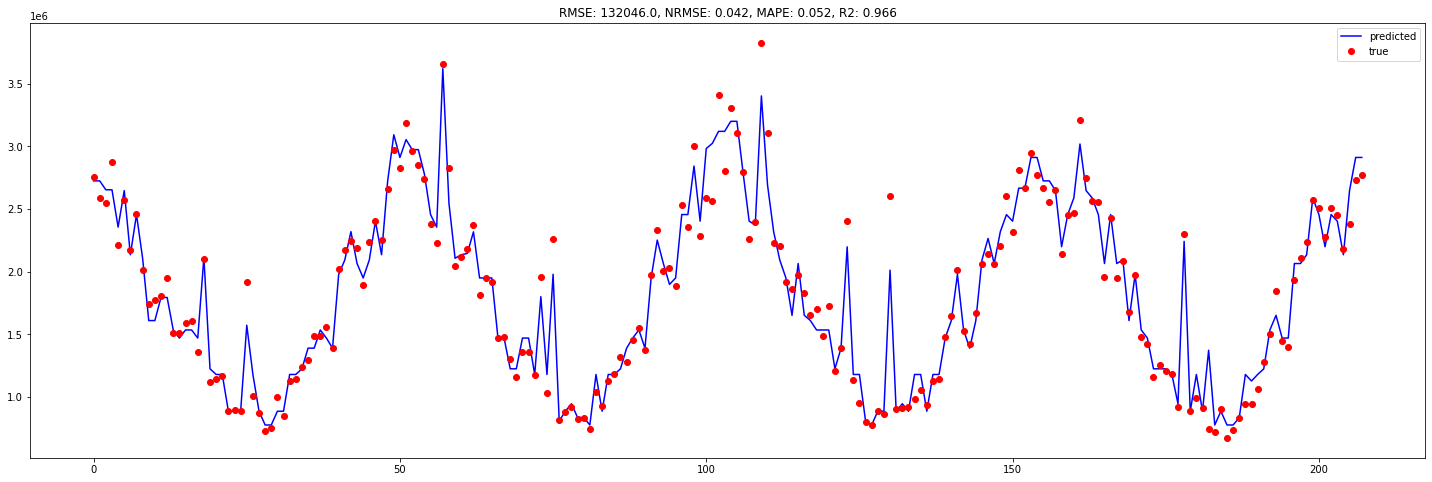

In [24]:
rmse_metric = mean_squared_error(y_true = data["revenue"], y_pred = prediction, squared=False)
mape_metric = mean_absolute_percentage_error(y_true = data["revenue"], y_pred = prediction)
nrmse_metric = nrmse(data["revenue"],  prediction)
r2_metric = r2_score(y_true = data["revenue"], y_pred = prediction)

fig, ax = plt.subplots(figsize = (25, 8))
_ = ax.plot(prediction, color = "blue", label = "predicted")
_ = ax.plot(data["revenue"], 'ro', label = "true")
_ = plt.title(f"RMSE: {np.round(rmse_metric)}, NRMSE: {np.round(nrmse_metric, 3)}, MAPE: {np.round(mape_metric, 3)}, R2: {np.round(r2_metric,3)}")
_ = ax.legend()

In [25]:
explainer = shap.TreeExplainer(rf)
#SAHPの取得
shap_values_train = explainer.shap_values(data[features])

#データフレームの作成
df_shap_values = pd.DataFrame(shap_values_train, columns=features)

In [26]:
def shap_feature_importance(shap_values, data,features ,figsize = (20, 10)):
    
    feature_list = data.columns
    
    if isinstance(shap_values, pd.DataFrame) == False:
        shap_v = pd.DataFrame(shap_values)
        shap_v.columns = feature_list
    else:
        shap_v = shap_values
    
        
    df_v = data.copy().reset_index().drop('index',axis=1)
    
    # 相関係数の作成
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # カラーサイン
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    # 可視化
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=figsize,legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")

invalid value encountered in true_divide
invalid value encountered in true_divide


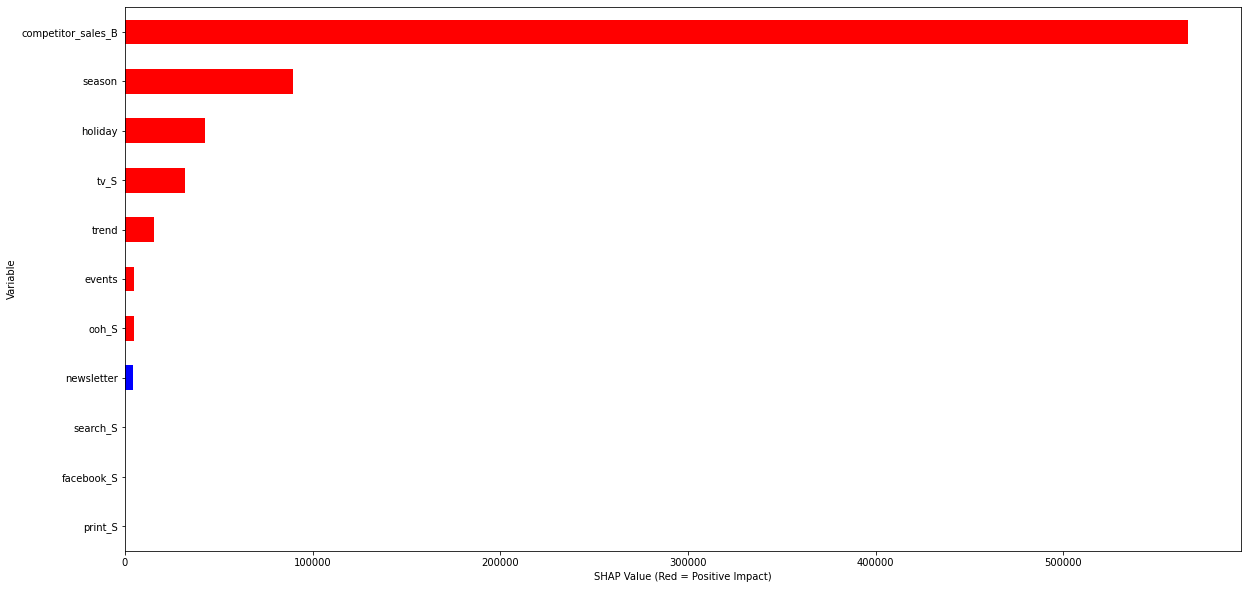

In [27]:
shap_feature_importance(df_shap_values, data[features], features)

# 支出の割合と影響度の算定

In [28]:
responses = pd.DataFrame(df_shap_values[media_channels].abs().sum(axis = 0), columns = ["effect_share"])
response_percentages = responses / responses.sum()
response_percentages

spends_percentages = pd.DataFrame(data[media_channels].sum(axis = 0) / data[media_channels].sum(axis = 0).sum(), columns = ["spend_share"])
spends_percentages

spend_effect_share = pd.merge(response_percentages, spends_percentages, left_index = True, right_index = True)
spend_effect_share = spend_effect_share.reset_index().rename(columns = {"index": "media"})

In [29]:
spend_effect_share

,media,effect_share,spend_share
0,tv_S,0.871599,0.338318
1,ooh_S,0.128401,0.246256
2,print_S,0.000000,0.084983
3,facebook_S,0.000000,0.195616
4,search_S,0.000000,0.134827


In [30]:
spend_effect_share.melt(id_vars=["media"])

,media,variable,value
0,tv_S,effect_share,0.871599
1,ooh_S,effect_share,0.128401
2,print_S,effect_share,0.000000
3,facebook_S,effect_share,0.000000
4,search_S,effect_share,0.000000
5,tv_S,spend_share,0.338318
6,ooh_S,spend_share,0.246256
7,print_S,spend_share,0.084983
8,facebook_S,spend_share,0.195616
9,search_S,spend_share,0.134827


In [31]:
spend_effect_share.melt(id_vars=["media"],value_vars = ["spend_share", "effect_share"])

,media,variable,value
0,tv_S,spend_share,0.338318
1,ooh_S,spend_share,0.246256
2,print_S,spend_share,0.084983
3,facebook_S,spend_share,0.195616
4,search_S,spend_share,0.134827
5,tv_S,effect_share,0.871599
6,ooh_S,effect_share,0.128401
7,print_S,effect_share,0.000000
8,facebook_S,effect_share,0.000000
9,search_S,effect_share,0.000000


# 可視化

In [32]:
spend_effect_share.head()

,media,effect_share,spend_share
0,tv_S,0.871599,0.338318
1,ooh_S,0.128401,0.246256
2,print_S,0.000000,0.084983
3,facebook_S,0.000000,0.195616
4,search_S,0.000000,0.134827


In [33]:
df_share = spend_effect_share.melt(id_vars=["media"],value_vars = ["spend_share", "effect_share"])

In [34]:
df_share.head()

,media,variable,value
0,tv_S,spend_share,0.338318
1,ooh_S,spend_share,0.246256
2,print_S,spend_share,0.084983
3,facebook_S,spend_share,0.195616
4,search_S,spend_share,0.134827


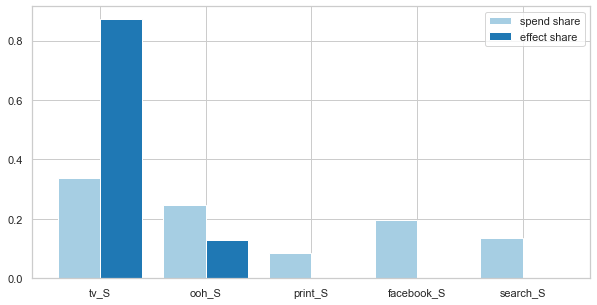

In [35]:

sns.set()
sns.set_style('whitegrid')
sns.set_palette('Paired')

x = np.array(spend_effect_share["media"].unique())
x_position = np.arange(len(x))


y_control = np.array(spend_effect_share["spend_share"])
y_stress = np.array(spend_effect_share["effect_share"])

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
ax.bar(x_position, y_control,width=0.4,  label='spend share')
ax.bar(x_position + 0.4,  y_stress, width=0.4, label='effect share')
ax.legend()
ax.set_xticks(x_position + 0.2)
ax.set_xticklabels(x)
plt.show()


In [36]:
def plot_shap_vs_spend(df_shap_values, x_input_interval_nontransformed, x_input_interval_transformed, features, media_channels, figsize=(25, 10)):
    for channel in media_channels:
    
        #index = features.index(channel)

        mean_spend = x_input_interval_nontransformed.loc[x_input_interval_nontransformed[channel] > 0, channel].mean()

        fig, ax = plt.subplots(figsize=figsize)
        sns.regplot(x = x_input_interval_transformed[channel], y = df_shap_values[channel], label = channel,
                    scatter_kws={'alpha': 0.65}, line_kws={'color': 'C2', 'linewidth': 6},
                    lowess=True, ax=ax).set(title=f'{channel}: Spend vs Shapley')
        ax.axhline(0, linestyle = "--", color = "black", alpha = 0.5)
        ax.axvline(mean_spend, linestyle = "--", color = "red", alpha = 0.5, label=f"Average Spend: {int(mean_spend)}")
        ax.set_xlabel(f"{channel} spend")
        ax.set_ylabel(f'SHAP Value for {channel}')
        plt.legend()

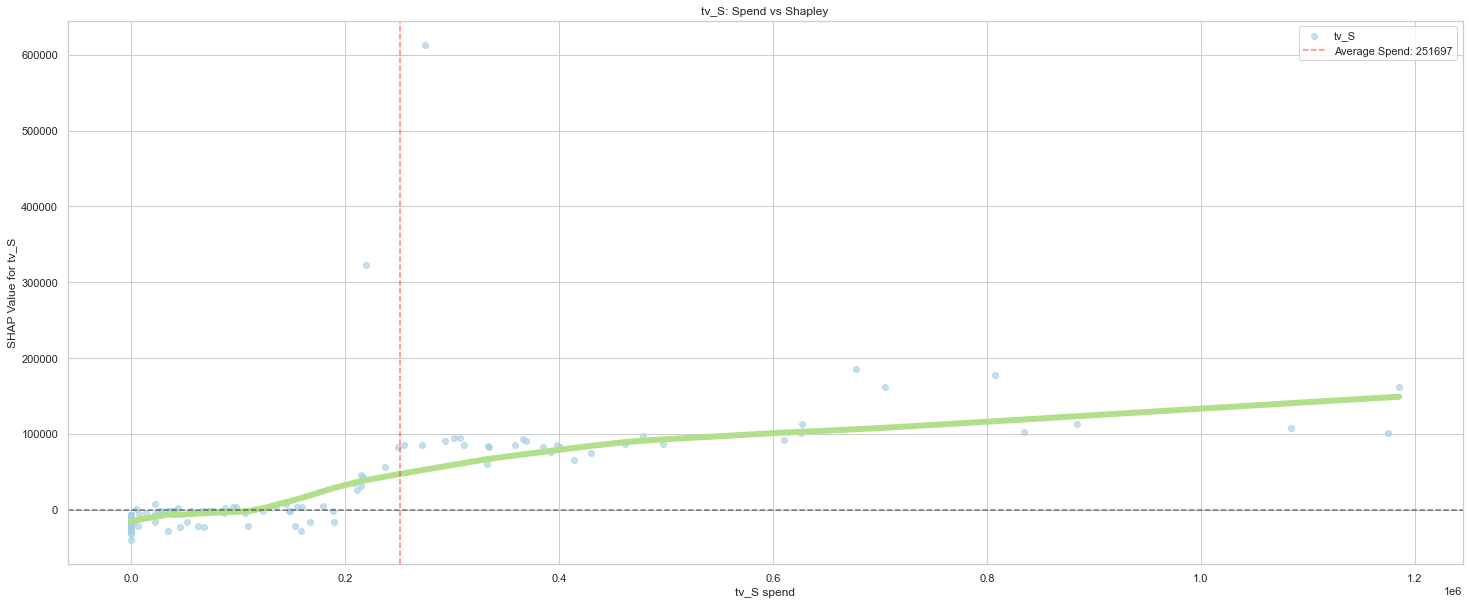

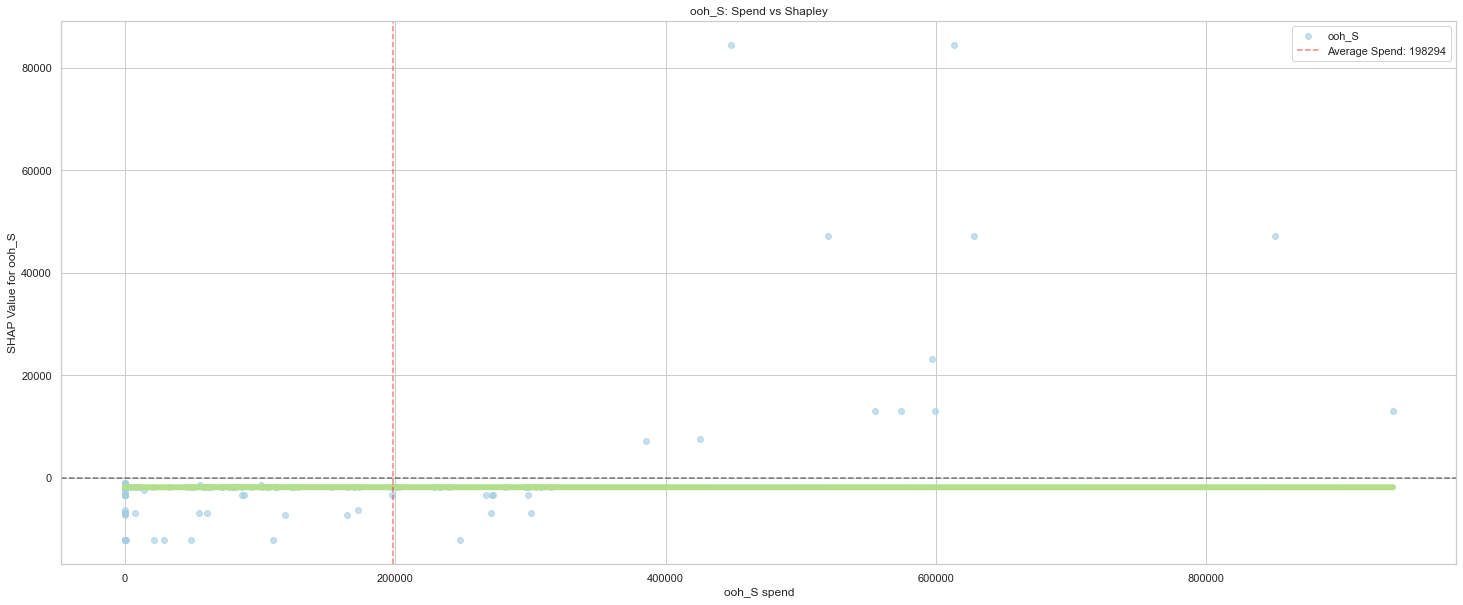

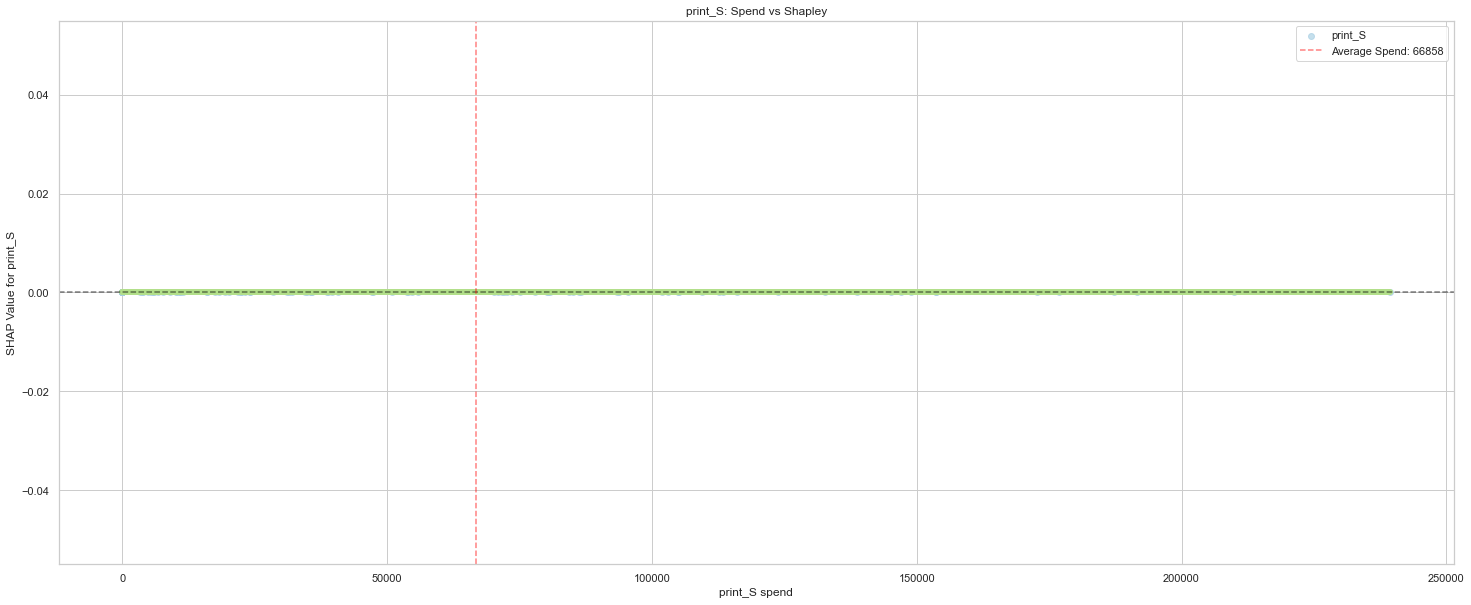

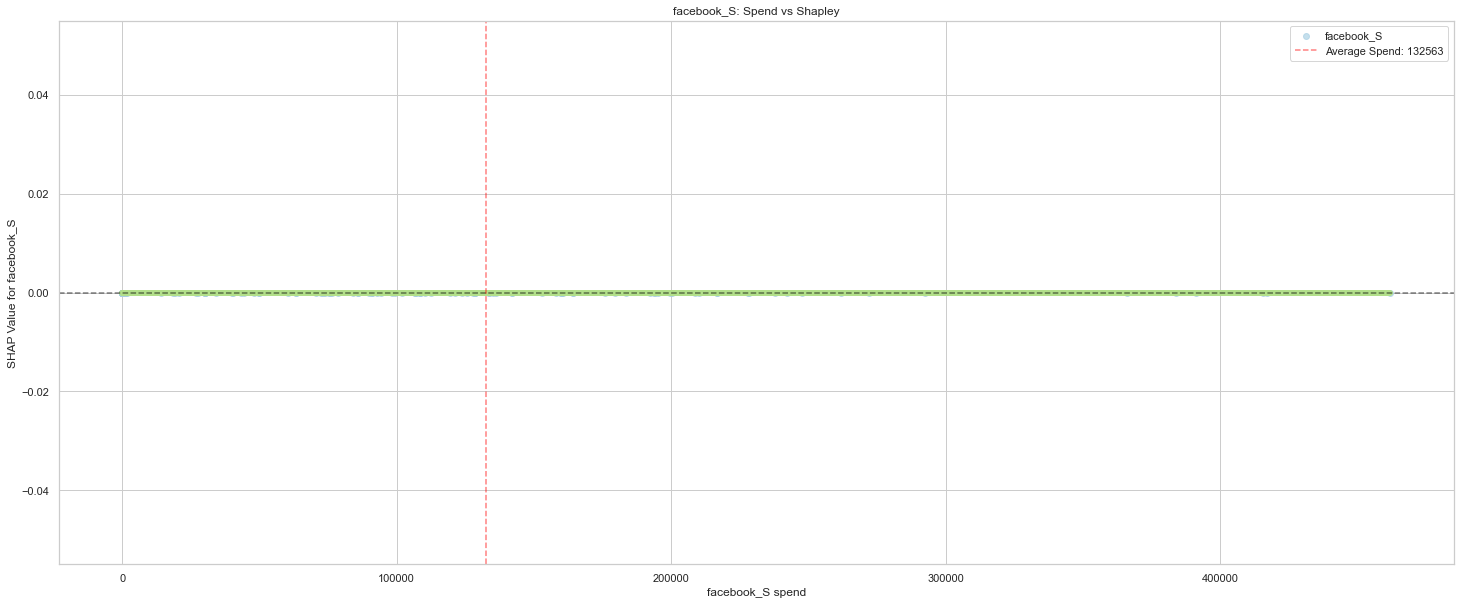

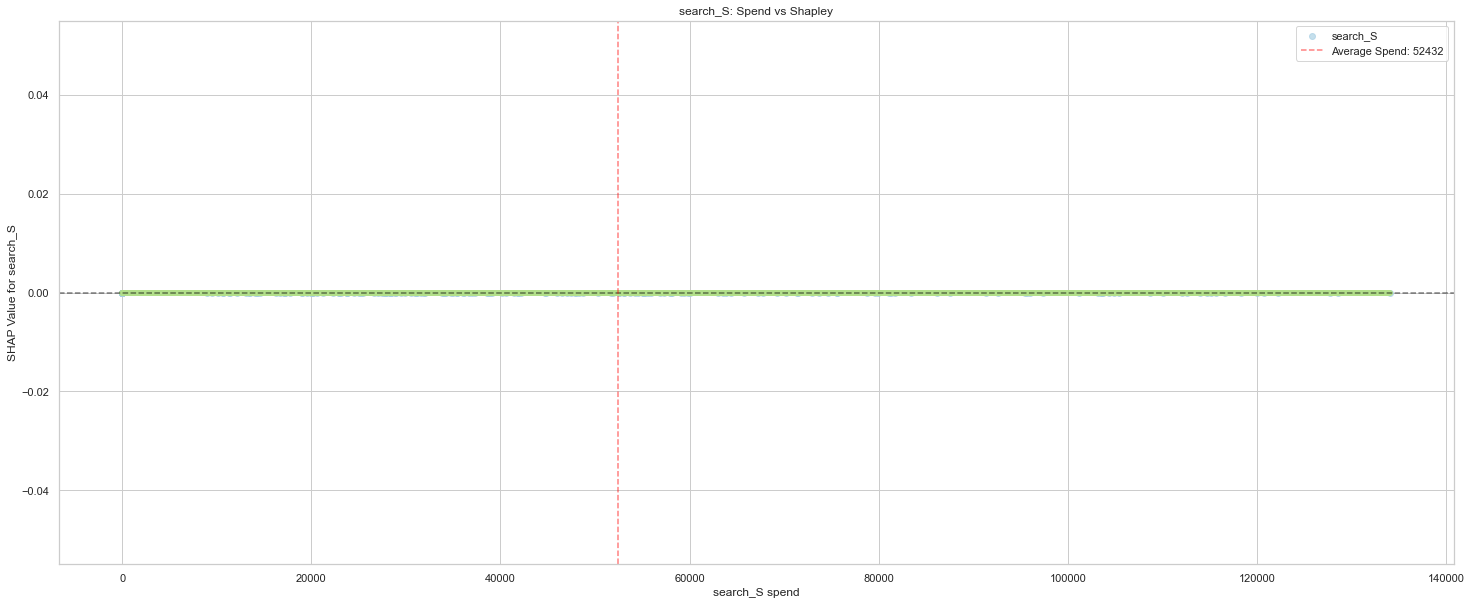

In [37]:
plot_shap_vs_spend(df_shap_values, data[features], data[features], features, media_channels)

# Adstockの影響を入れる

In [38]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.utils.validation import check_is_fitted

class AdstockGeometric(BaseEstimator, TransformerMixin):
    def __init__(self, alpha=0.5):
        self.alpha = alpha
        
    def fit(self, X, y=None):
        X = check_array(X)
        self._check_n_features(X, reset=True)
        return self
    
    def transform(self, X: np.ndarray):
        check_is_fitted(self)
        X = check_array(X)
        self._check_n_features(X, reset=False)
        x_decayed = np.zeros_like(X)
        x_decayed[0] = X[0]
        
        for xi in range(1, len(x_decayed)):
            x_decayed[xi] = X[xi] + self.alpha* x_decayed[xi - 1]
        return x_decayed

In [39]:
adstock_features_params = {}
adstock_features_params["tv_S_adstock"] = 0.3
adstock_features_params["ooh_S_adstock"] = 0.1
adstock_features_params["print_S_adstock"] = 0.1
adstock_features_params["facebook_S_adstock"] = 0.4
adstock_features_params["search_S_adstock"] = 0.3
adstock_features_params["newsletter_adstock"] = 0.4

In [40]:
adstock_features = media_channels + organic_channels

In [41]:
adstock_features

['tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S', 'newsletter']

In [42]:
data_temp = data.copy()
data_temp

,date,revenue,tv_S,ooh_S,print_S,facebook_I,search_clicks_P,search_S,competitor_sales_B,facebook_S,events,newsletter,trend,season,holiday
0,2015-11-23,2.754372e+06,167687.6,0,95463.666667,7.290385e+07,0.000000,0,8125009,228213.987444,0.0,19401.653846,2.867268e+06,1.124162e+06,0.00000
1,2015-11-30,2.584277e+06,214600.9,0,0.000000,1.658110e+07,29511.715457,31000,7901549,34258.573511,0.0,14791.000000,2.868317e+06,8.938685e+05,0.00000
2,2015-12-07,2.547387e+06,0.0,248022,3404.000000,4.995477e+07,36132.358958,28400,8300197,127691.261335,0.0,14544.000000,2.869366e+06,7.100751e+05,0.00000
3,2015-12-14,2.875220e+06,625877.3,0,132600.000000,3.164930e+07,36804.210958,31900,8122883,84014.720306,0.0,2800.000000,2.870416e+06,6.973235e+05,0.00000
4,2015-12-21,2.215953e+06,0.0,520005,0.000000,8.802269e+06,28401.744069,27100,7105985,20687.478156,0.0,15478.000000,2.871465e+06,8.030710e+05,466272.31392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,2019-10-14,2.456240e+06,0.0,60433,153723.666667,0.000000e+00,152840.323412,112100,7612762,0.000000,0.0,28157.000000,2.878593e+06,7.397707e+05,0.00000
204,2019-10-21,2.182825e+06,154917.6,0,0.000000,5.688196e+07,103680.047821,103700,6701667,133624.575524,0.0,10644.000000,2.877750e+06,7.933283e+05,0.00000
205,2019-10-28,2.377707e+06,21982.5,14094,17476.000000,0.000000e+00,138387.704138,114700,7688920,0.000000,0.0,9597.000000,2.876907e+06,8.658485e+05,0.00000
206,2019-11-04,2.732825e+06,22453.0,0,24051.333333,0.000000e+00,151707.990462,134100,8815710,0.000000,0.0,90189.000000,2.876064e+06,1.012942e+06,0.00000


In [43]:
adstock_alphas = {}

In [44]:
for feature in adstock_features:
    adstock_param = f"{feature}_adstock"
    adstock_alpha = adstock_features_params[adstock_param]
    adstock_alphas[feature] = adstock_alpha

    #adstock transformation
    x_feature = data[feature].values.reshape(-1, 1)
    temp_adstock = AdstockGeometric(alpha = adstock_alpha).fit_transform(x_feature)
    data_temp[feature] = temp_adstock

In [46]:
data_temp.head()

,date,revenue,tv_S,ooh_S,print_S,facebook_I,search_clicks_P,search_S,competitor_sales_B,facebook_S,events,newsletter,trend,season,holiday
0,2015-11-23,2.754372e+06,167687.60000,0,95463.666667,7.290385e+07,0.000000,0,8125009,228213.987444,0.0,19401.653846,2.867268e+06,1.124162e+06,0.00000
1,2015-11-30,2.584277e+06,264907.18000,0,9546.366667,1.658110e+07,29511.715457,31000,7901549,125544.168488,0.0,22551.661538,2.868317e+06,8.938685e+05,0.00000
2,2015-12-07,2.547387e+06,79472.15400,248022,4358.636667,4.995477e+07,36132.358958,37700,8300197,177908.928730,0.0,23564.664615,2.869366e+06,7.100751e+05,0.00000
3,2015-12-14,2.875220e+06,649718.94620,24802,133035.863667,3.164930e+07,36804.210958,43210,8122883,155178.291798,0.0,12225.865846,2.870416e+06,6.973235e+05,0.00000
4,2015-12-21,2.215953e+06,194915.68386,522485,13303.586367,8.802269e+06,28401.744069,40063,7105985,82758.794875,0.0,20368.346338,2.871465e+06,8.030710e+05,466272.31392


In [47]:
data.head()

,date,revenue,tv_S,ooh_S,print_S,facebook_I,search_clicks_P,search_S,competitor_sales_B,facebook_S,events,newsletter,trend,season,holiday
0,2015-11-23,2.754372e+06,167687.6,0,95463.666667,7.290385e+07,0.000000,0,8125009,228213.987444,0.0,19401.653846,2.867268e+06,1.124162e+06,0.00000
1,2015-11-30,2.584277e+06,214600.9,0,0.000000,1.658110e+07,29511.715457,31000,7901549,34258.573511,0.0,14791.000000,2.868317e+06,8.938685e+05,0.00000
2,2015-12-07,2.547387e+06,0.0,248022,3404.000000,4.995477e+07,36132.358958,28400,8300197,127691.261335,0.0,14544.000000,2.869366e+06,7.100751e+05,0.00000
3,2015-12-14,2.875220e+06,625877.3,0,132600.000000,3.164930e+07,36804.210958,31900,8122883,84014.720306,0.0,2800.000000,2.870416e+06,6.973235e+05,0.00000
4,2015-12-21,2.215953e+06,0.0,520005,0.000000,8.802269e+06,28401.744069,27100,7105985,20687.478156,0.0,15478.000000,2.871465e+06,8.030710e+05,466272.31392


In [48]:
scores = []

tscv = TimeSeriesSplit(n_splits=3, test_size = 20)

for train_index, test_index in tscv.split(data_temp):
    x_train = data_temp.iloc[train_index][features]
    y_train =  data_temp[target].values[train_index]

    x_test = data_temp.iloc[test_index][features]
    y_test = data_temp[target].values[test_index]

    #Random Forest
    params = {"n_estimators": n_estimators, 
               "min_samples_leaf":min_samples_leaf, 
               "min_samples_split" : min_samples_split,
               "max_depth" : max_depth, 
               "ccp_alpha" : ccp_alpha, 
               "bootstrap" : bootstrap
             }

    rf = RandomForestRegressor(random_state=0, **params)
    print(x_train.isna().sum())
    rf.fit(x_train, y_train)
    prediction = rf.predict(x_test)

    rmse = mean_squared_error(y_true = y_test, y_pred = prediction, squared = False)
    scores.append(rmse)

trend                 0
season                0
holiday               0
competitor_sales_B    0
events                0
tv_S                  0
ooh_S                 0
print_S               0
facebook_S            0
search_S              0
newsletter            0
dtype: int64
trend                 0
season                0
holiday               0
competitor_sales_B    0
events                0
tv_S                  0
ooh_S                 0
print_S               0
facebook_S            0
search_S              0
newsletter            0
dtype: int64
trend                 0
season                0
holiday               0
competitor_sales_B    0
events                0
tv_S                  0
ooh_S                 0
print_S               0
facebook_S            0
search_S              0
newsletter            0
dtype: int64


In [50]:
prediction = rf.predict(data_temp[features])

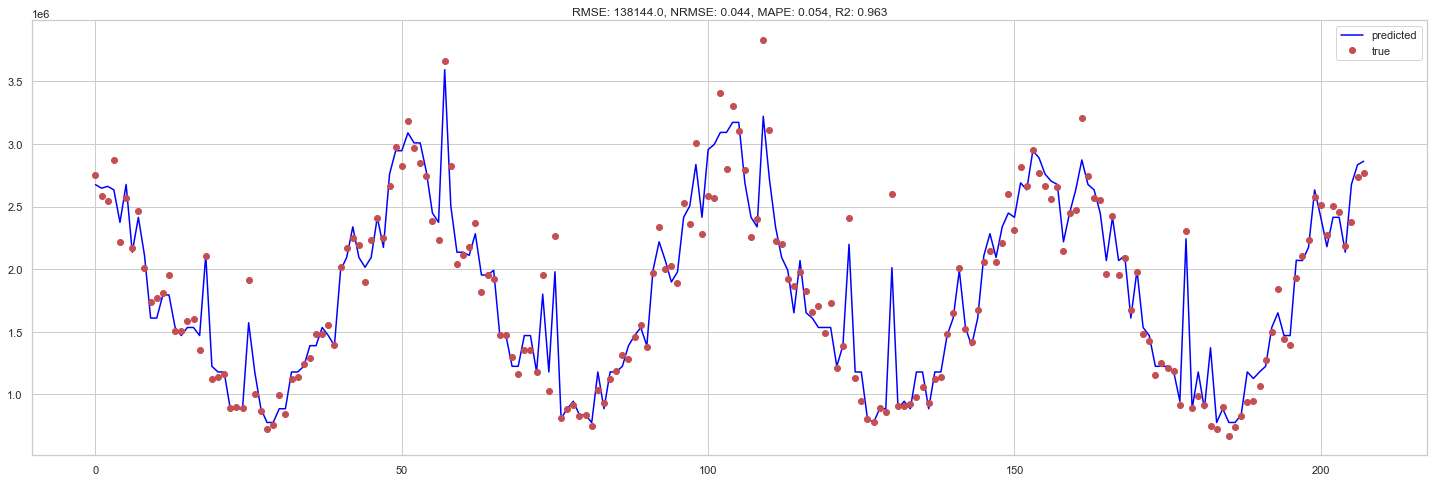

In [51]:
rmse_metric = mean_squared_error(y_true = data_temp["revenue"], y_pred = prediction, squared=False)
mape_metric = mean_absolute_percentage_error(y_true = data_temp["revenue"], y_pred = prediction)
nrmse_metric = nrmse(data_temp["revenue"],  prediction)
r2_metric = r2_score(y_true = data_temp["revenue"], y_pred = prediction)

fig, ax = plt.subplots(figsize = (25, 8))
_ = ax.plot(prediction, color = "blue", label = "predicted")
_ = ax.plot(data["revenue"], 'ro', label = "true")
_ = plt.title(f"RMSE: {np.round(rmse_metric)}, NRMSE: {np.round(nrmse_metric, 3)}, MAPE: {np.round(mape_metric, 3)}, R2: {np.round(r2_metric,3)}")
_ = ax.legend()

In [52]:
explainer = shap.TreeExplainer(rf)
shap_values_train = explainer.shap_values(data_temp[features])
df_shap_values = pd.DataFrame(shap_values_train, columns=features)

invalid value encountered in true_divide
invalid value encountered in true_divide


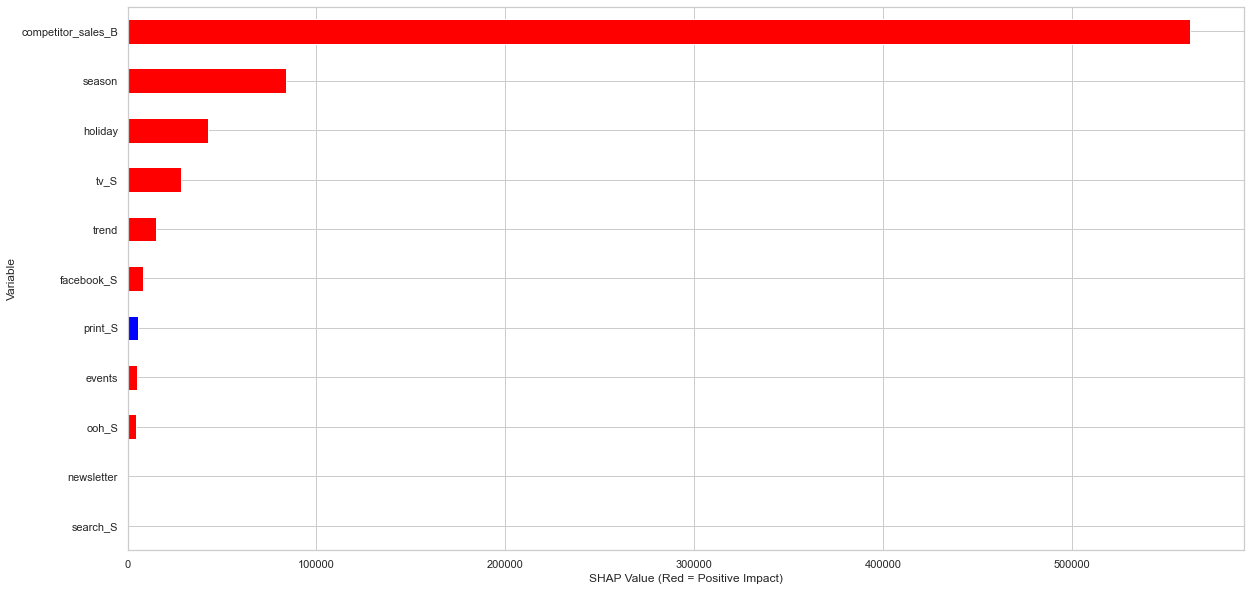

In [53]:
shap_feature_importance(df_shap_values, data_temp[features], features)

In [55]:
responses = pd.DataFrame(df_shap_values[media_channels].abs().sum(axis = 0), columns = ["effect_share"])
response_percentages = responses / responses.sum()
response_percentages

spends_percentages = pd.DataFrame(data[media_channels].sum(axis = 0) / data[media_channels].sum(axis = 0).sum(), columns = ["spend_share"])
spends_percentages

spend_effect_share = pd.merge(response_percentages, spends_percentages, left_index = True, right_index = True)
spend_effect_share = spend_effect_share.reset_index().rename(columns = {"index": "media"})

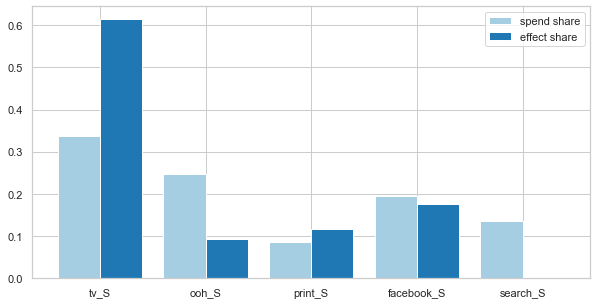

In [56]:
sns.set()
sns.set_style('whitegrid')
sns.set_palette('Paired')

x = np.array(spend_effect_share["media"].unique())
x_position = np.arange(len(x))


y_control = np.array(spend_effect_share["spend_share"])
y_stress = np.array(spend_effect_share["effect_share"])

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
ax.bar(x_position, y_control,width=0.4,  label='spend share')
ax.bar(x_position + 0.4,  y_stress, width=0.4, label='effect share')
ax.legend()
ax.set_xticks(x_position + 0.2)
ax.set_xticklabels(x)
plt.show()


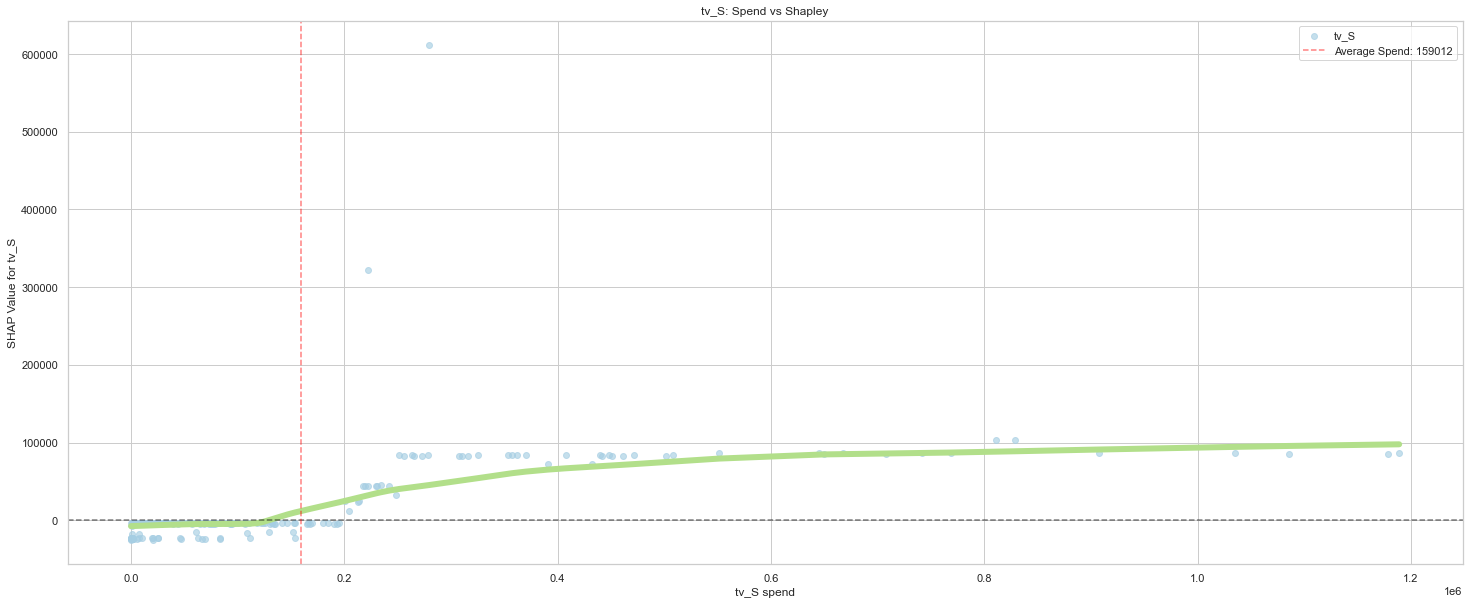

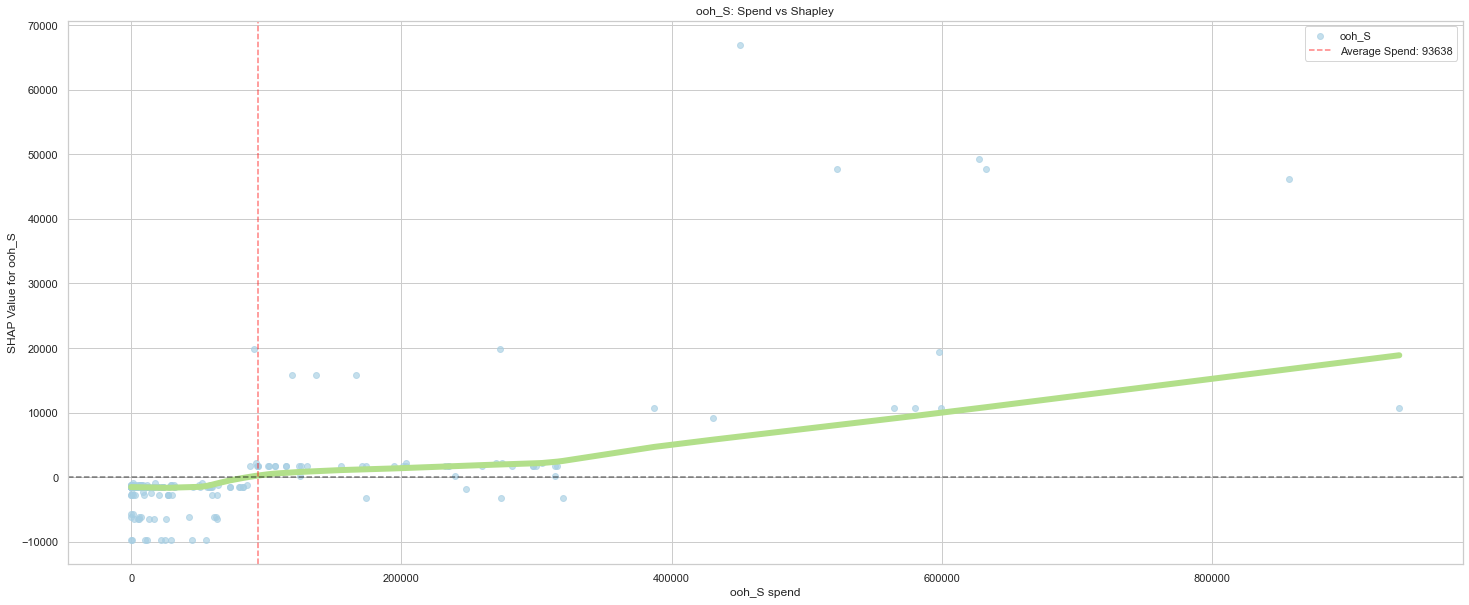

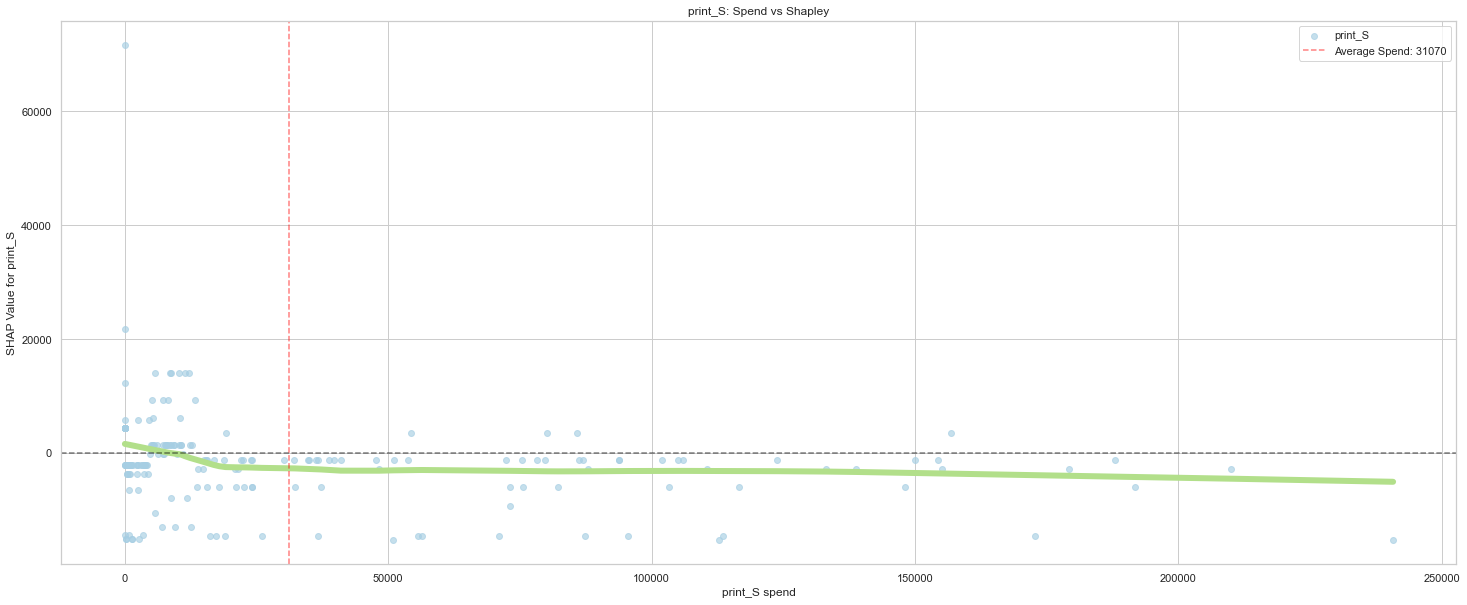

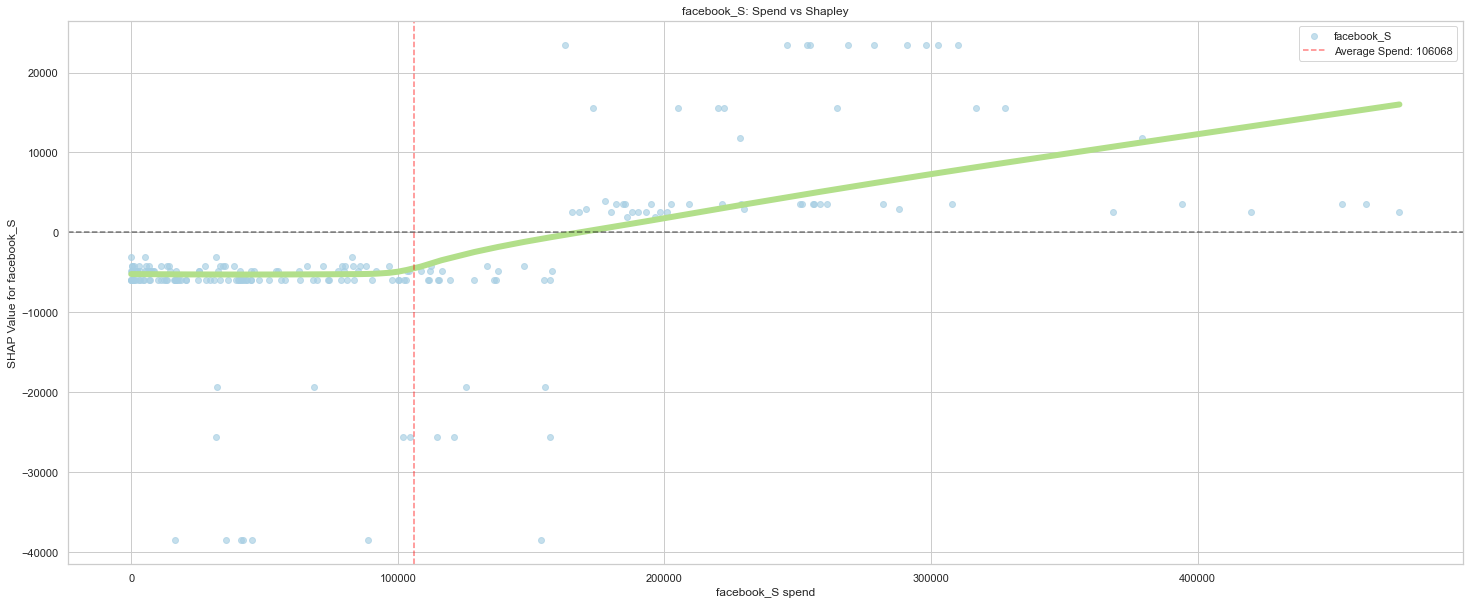

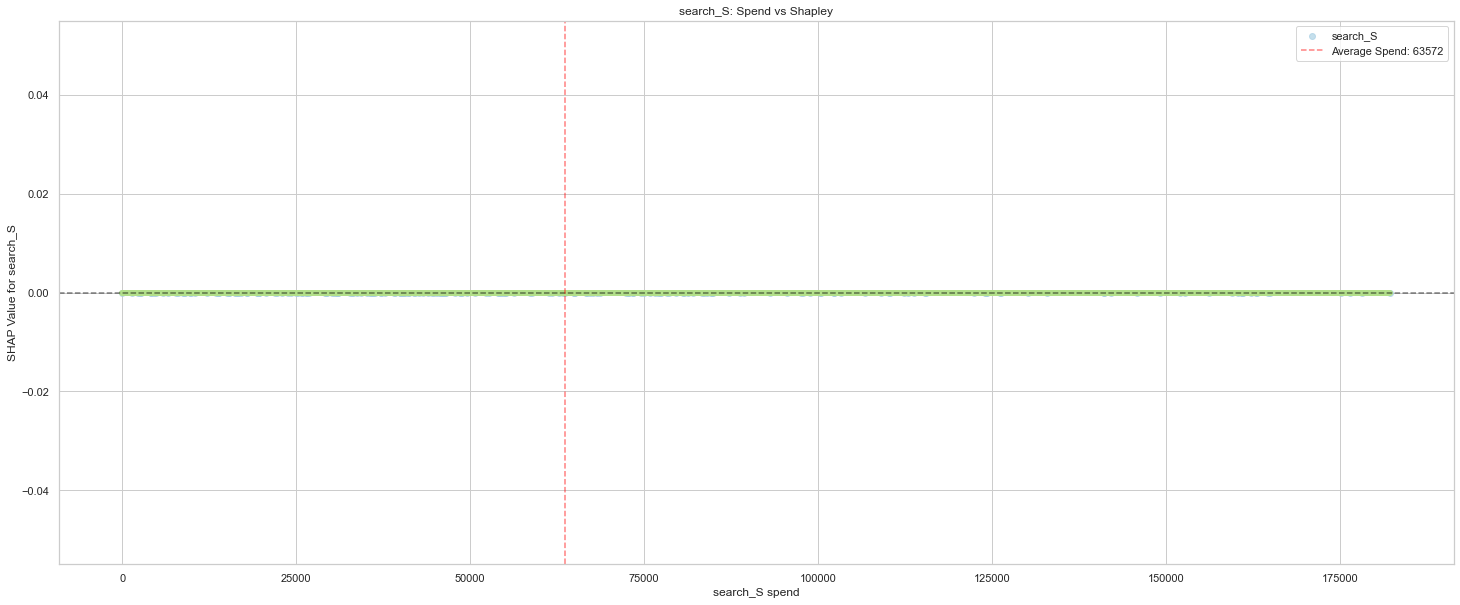

In [57]:
plot_shap_vs_spend(df_shap_values, data_temp[features], data_temp[features], features, media_channels)